BRIGHTNESS HISTOGRAM FOR CELLPHONE DATA

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from math import ceil


In [33]:
def face_detection(frame, use_larger_box=True, larger_box_coef=1.5):
        """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bouding box.
        """

        detector = cv2.CascadeClassifier(
           './dataset/haarcascade_frontalface_default.xml')
        face_zone = detector.detectMultiScale(frame)
        if len(face_zone) < 1:
            print("ERROR: No Face Detected")
            face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
        elif len(face_zone) >= 2:
            face_box_coor = np.argmax(face_zone, axis=0)
            face_box_coor = face_zone[face_box_coor[2]]
            print("Warning: More than one faces are detected(Only cropping the biggest one.)")
        else:
            face_box_coor = face_zone[0]
        if use_larger_box:
            face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
            face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
            face_box_coor[2] = larger_box_coef * face_box_coor[2]
            face_box_coor[3] = larger_box_coef * face_box_coor[3]
        return face_box_coor


def crop_face_resize(frames, use_face_detection=True, use_larger_box=True, larger_box_coef=1.5, use_dynamic_detection=False, 
                         detection_freq=10, use_median_box=False, width=72, height=72):
        """Crop face and resize frames.

        Args:
            frames(np.array): Video frames.
            use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
            detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
            width(int): Target width for resizing.
            height(int): Target height for resizing.
            use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
            use_face_detection(bool):  Whether crop the face.
            larger_box_coef(float): the coefficient of the larger region(height and weight),
                                the middle point of the detected region will stay still during the process of enlarging.
        Returns:
            resized_frames(list[np.array(float)]): Resized and cropped frames
        """
        # Face Cropping
        if use_dynamic_detection:
            num_dynamic_det = ceil(frames.shape[0] / detection_freq)
        else:
            num_dynamic_det = 1
        face_region_all = []
        # Perform face detection by num_dynamic_det" times.
        for idx in range(num_dynamic_det):
            if use_face_detection:
                face_region_all.append(face_detection(frames[detection_freq * idx], use_larger_box, larger_box_coef))
            else:
                face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
        face_region_all = np.asarray(face_region_all, dtype='int')
        if use_median_box:
            # Generate a median bounding box based on all detected face regions
            face_region_median = np.median(face_region_all, axis=0).astype('int')


        # Frame Resizing
        resized_frames = np.zeros((frames.shape[0], height, width, 3))
        for i in range(0, frames.shape[0]):
            frame = frames[i]
            if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
                reference_index = i // detection_freq
            else:  # use the first region obtrained from the first frame.
                reference_index = 0
            if use_face_detection:
                if use_median_box:
                    face_region = face_region_median
                else:
                    face_region = face_region_all[reference_index]
                frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
                        max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]
            resized_frames[i] = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        return resized_frames


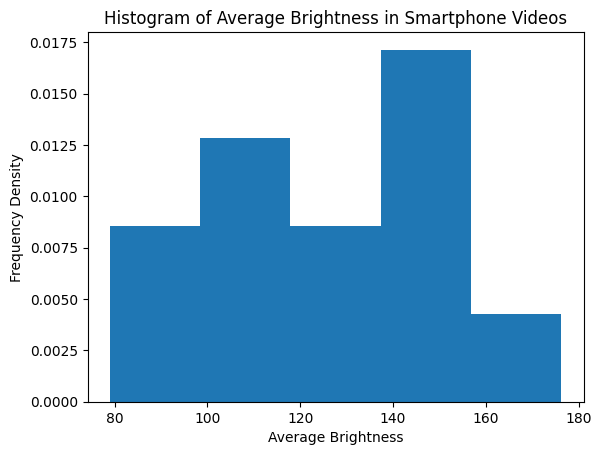

In [34]:
# Dictionary to store Subject, Video File and its Average Brightness
average_brightness_dict = {}

# Define your face detection function here if not already imported

# Function to calculate brightness
def calculate_brightness(frame):
    # Your implementation of brightness calculation
    pass

# Loop through each subject folder
root_directory = '/Users/qpingwin/labs/KlarityAII/My_dataset'
for subject in os.listdir(root_directory):
    subject_path = os.path.join(root_directory, subject)
    
    # Skip if not a directory
    if not os.path.isdir(subject_path):
        continue
    
    # Loop through each file in the subject folder
    for file_name in os.listdir(subject_path):
        # Check if the file is a .avi video file
        if file_name.endswith('.avi'):
            video_file_path = os.path.join(subject_path, file_name)

            # Initialise VideoCapture object
            cap = cv2.VideoCapture(video_file_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            sum_brightness = 0.0
            j=0
            while(cap.isOpened()):
                ret, frame = cap.read()
                if j==0: 
                    face_box_coor = face_detection(frame)
                    j = j+1
                    
                    

                
                if not ret:
                    break
                
               
                
                # Crop the face from the frame
                cropped_face = frame[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                # Calculate brightness for the cropped face
                brightness_now = np.mean(cropped_face)
                sum_brightness =sum_brightness+ brightness_now

            # Calculate the average brightness for the video
            average_brightness = sum_brightness / total_frames
            average_brightness_dict[f"{subject}/{file_name}"] = average_brightness
            cap.release()

# Generate Histogram
plt.hist(average_brightness_dict.values(), bins='auto', density=True)
plt.title('Histogram of Average Brightness in Smartphone Videos')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency Density')
plt.show()


Same for UBFC dataset 

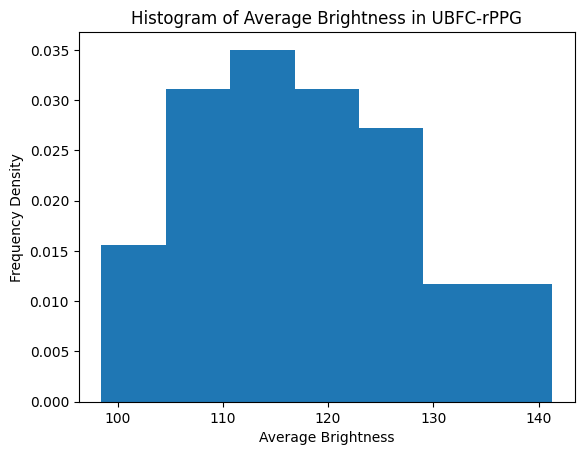

In [35]:
# Dictionary to store Subject, Video File and its Average Brightness
average_brightness_dict = {}

# Loop through each subject folder
root_directory = '/Users/qpingwin/labs/KlarityAII/full_UBFC'
for subject in os.listdir(root_directory):
    subject_path = os.path.join(root_directory, subject)
    
    # Skip if not a directory
    if not os.path.isdir(subject_path):
        continue
    
    # Loop through each file in the subject folder
    for file_name in os.listdir(subject_path):
        # Check if the file is a .avi video file
        if file_name.endswith('.avi'):
            video_file_path = os.path.join(subject_path, file_name)

            # Initialise VideoCapture object
            cap = cv2.VideoCapture(video_file_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            sum_brightness = 0.0
            j=0

            while(cap.isOpened()):
                ret, frame = cap.read()
                if j==0: 
                    face_box_coor = face_detection(frame)
                    j = j+1
                if not ret:
                    break

                cropped_face = frame[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                # Calculate brightness for the cropped face
                brightness_now = np.mean(cropped_face)
                sum_brightness =sum_brightness+ brightness_now

            # Calculate the average brightness for the video
            average_brightness = sum_brightness / total_frames
            average_brightness_dict[f"{subject}/{file_name}"] = average_brightness
            cap.release()

# Generate Histogram
plt.hist(average_brightness_dict.values(), bins='auto', density=True)
plt.title('Histogram of Average Brightness in UBFC-rPPG')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency Density')
plt.show()


In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_brightness(frame):
    return np.mean(frame)

def augment_brightness(frame, brightness_factor):
    return np.clip(frame * brightness_factor, 0, 255).astype(np.uint8)

original_brightness_per_video = []
augmented_brightness_per_video = []

# Loop over all subjects in the root folder
for subject_folder in os.listdir('/Users/qpingwin/labs/KlarityAII/full_UBFC'):
    
    subject_path = os.path.join('/Users/qpingwin/labs/KlarityAII/full_UBFC', subject_folder)

    if os.path.isdir(subject_path):
        
        for file in os.listdir(subject_path):
            if file.endswith('.avi'):
                video_path = os.path.join(subject_path, file)
                cap = cv2.VideoCapture(video_path)
                frame_brightness_values = []
                j=0

                while cap.isOpened():
                    ret, frame = cap.read()
                    if j==0: 
                        face_box_coor = face_detection(frame)
                        j = j+1
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    cropped_face = frame_rgb[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                    frame_brightness_values.append(get_brightness(cropped_face))

                # Compute original average brightness for this video
                avg_original_brightness = np.mean(frame_brightness_values)
                original_brightness_per_video.append(avg_original_brightness)

                # Compute brightness factor to reach target brightness
                target_brightness = np.random.uniform(80, 175)
                brightness_factor = target_brightness / avg_original_brightness
                
                # Reset capture to augment frames with consistent brightness
                cap = cv2.VideoCapture(video_path)
                frame_brightness_values = []
                
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    cropped_face = frame_rgb[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                    augmented_frame = augment_brightness(cropped_face, brightness_factor)
                    frame_brightness_values.append(get_brightness(augmented_frame))

                # Compute augmented average brightness for this video
                avg_augmented_brightness = np.mean(frame_brightness_values)
                augmented_brightness_per_video.append(avg_augmented_brightness)

                cap.release()




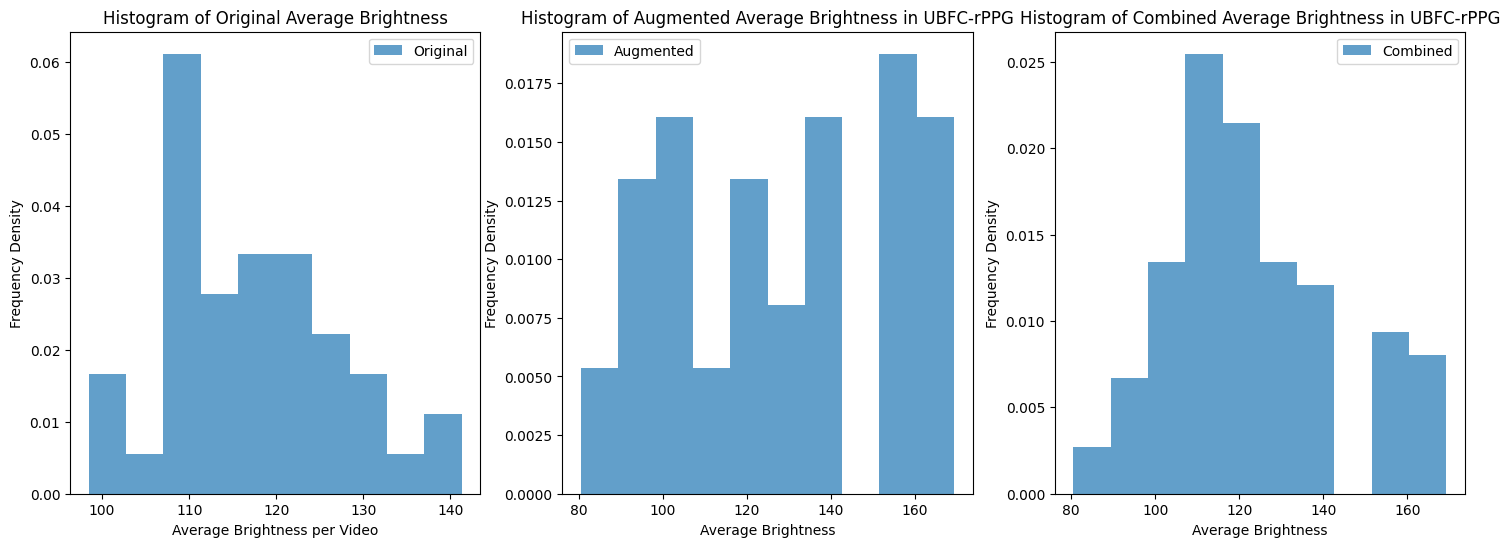

In [39]:
# Create histograms
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(original_brightness_per_video, bins=10, alpha=0.7, label='Original', density=True)
plt.title('Histogram of Original Average Brightness')
plt.xlabel('Average Brightness per Video')
plt.ylabel('Frequency Density')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(augmented_brightness_per_video, bins=10, alpha=0.7, label='Augmented', density=True)
plt.title('Histogram of Augmented Average Brightness in UBFC-rPPG')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency Density')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(original_brightness_per_video + augmented_brightness_per_video, bins=10, alpha=0.7, label='Combined', density=True)
plt.title('Histogram of Combined Average Brightness in UBFC-rPPG')
plt.xlabel('Average Brightness')
plt.ylabel('Frequency Density')
plt.legend()

plt.show()

FOR PURE

PUREEE

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_brightness(frame):
    return np.mean(frame)

video_mean_original_brightness_list = []

# Loop over all main folders (e.g., 01-01, 01-02)
for main_folder in os.listdir('/Users/qpingwin/labs/KlarityAII/Pure_dataset'):
    if main_folder == 'pure':
        continue  # Skip this iteration and move to the next folder
    main_path = os.path.join('/Users/qpingwin/labs/KlarityAII/Pure_dataset', main_folder)
    
    if os.path.isdir(main_path):
        for sub_folder in os.listdir(main_path):
            sub_path = os.path.join(main_path, sub_folder)
            j=0
            if os.path.isdir(sub_path):
                original_brightness_values = []
                for file in os.listdir(sub_path):
                    
                    if file.endswith('.png'):
                        frame_path = os.path.join(sub_path, file)
                        frame = cv2.imread(frame_path)
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        if j==0: 
                            face_box_coor = face_detection(frame_rgb)
                            j = j+1
                        cropped_face = frame_rgb[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                        
                        
                        
                        original_brightness = get_brightness(cropped_face)
                        original_brightness_values.append(original_brightness)
                
                avg_original_brightness = np.mean(original_brightness_values)
                video_mean_original_brightness_list.append(avg_original_brightness)


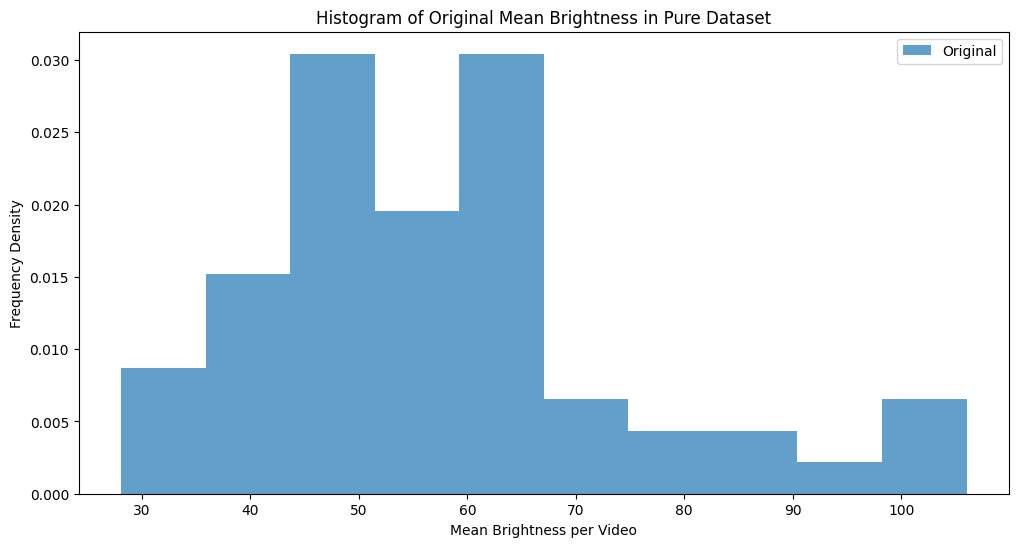

In [41]:
# Create histogram
plt.figure(figsize=(12, 6))

plt.hist(video_mean_original_brightness_list, bins=10, alpha=0.7, label='Original', density=True)
plt.title('Histogram of Original Mean Brightness in Pure Dataset')
plt.xlabel('Mean Brightness per Video')
plt.ylabel('Frequency Density')
plt.legend()

plt.show()


In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_brightness(frame):
    return np.mean(frame)

def augment_brightness(frame, brightness_factor):
    return np.clip(frame * brightness_factor, 0, 255).astype(np.uint8)

video_mean_original_brightness_list = []
video_mean_augmented_brightness_list = []

# Loop over all main folders (e.g., 01-01, 01-02)
for main_folder in os.listdir('/Users/qpingwin/labs/KlarityAII/Pure_dataset'):
    if main_folder == 'pure':
        continue  # Skip this iteration and move to the next folder
    main_path = os.path.join('/Users/qpingwin/labs/KlarityAII/Pure_dataset', main_folder)
    
    if os.path.isdir(main_path):
        for sub_folder in os.listdir(main_path):
            sub_path = os.path.join(main_path, sub_folder)
            j=0
            if os.path.isdir(sub_path):
                original_brightness_values = []
                augmented_brightness_values = []
                
                # Create a deterministic brightness factor for this folder
                target_brightness = np.random.uniform(80, 175)
                
                for file in os.listdir(sub_path):
                    if file.endswith('.png'):
                        frame_path = os.path.join(sub_path, file)
                        frame = cv2.imread(frame_path)
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        if j==0: 
                            face_box_coor = face_detection(frame_rgb)
                            j = j+1
                        cropped_face = frame_rgb[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                        
                        original_brightness = get_brightness(cropped_face)
                        original_brightness_values.append(original_brightness)
                
                avg_original_brightness = np.mean(original_brightness_values)
                video_mean_original_brightness_list.append(avg_original_brightness)
                
                brightness_factor = target_brightness / avg_original_brightness
                
                for file in os.listdir(sub_path):
                    if file.endswith('.png'):
                        frame_path = os.path.join(sub_path, file)
                        frame = cv2.imread(frame_path)
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        cropped_face = frame_rgb[face_box_coor[1]:face_box_coor[1]+face_box_coor[3], 
                                     face_box_coor[0]:face_box_coor[0]+face_box_coor[2]]
                        
                        augmented_frame = augment_brightness(cropped_face, brightness_factor)
                        augmented_brightness = get_brightness(augmented_frame)
                        augmented_brightness_values.append(augmented_brightness)
                
                avg_augmented_brightness = np.mean(augmented_brightness_values)
                video_mean_augmented_brightness_list.append(avg_augmented_brightness)



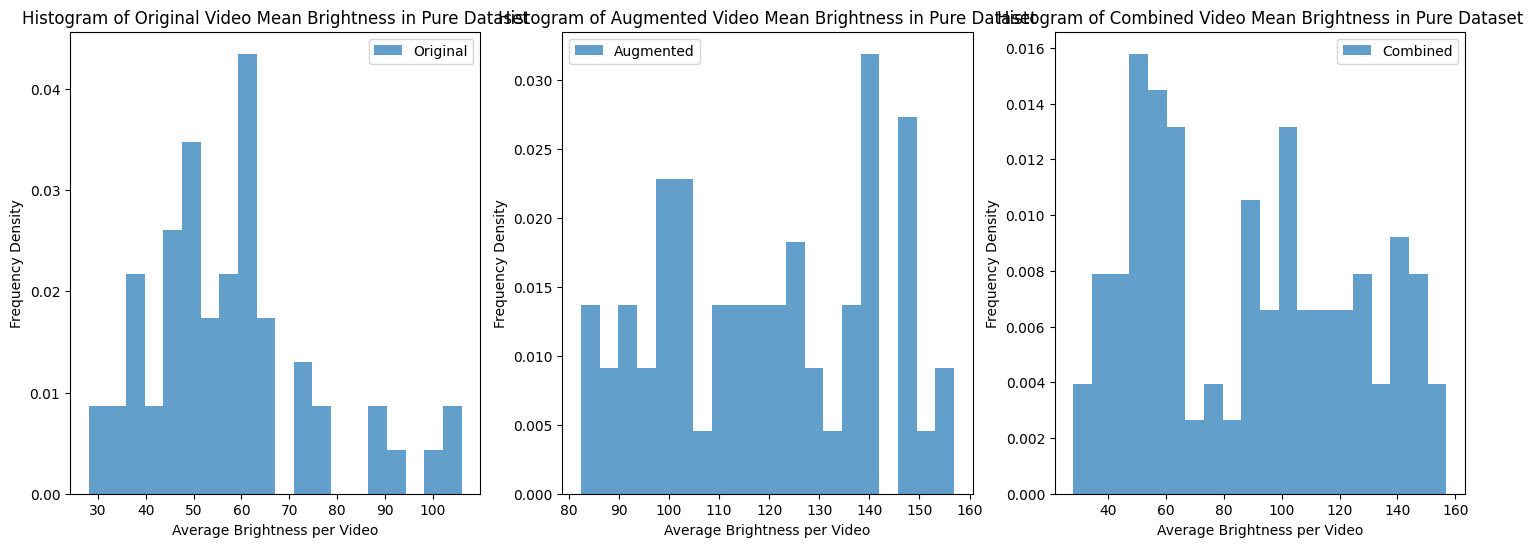

In [45]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(video_mean_original_brightness_list, bins=20, alpha=0.7, label='Original', density=True)
plt.title('Histogram of Original Video Mean Brightness in Pure Dataset')
plt.xlabel('Average Brightness per Video')
plt.ylabel('Frequency Density')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(video_mean_augmented_brightness_list, bins=20, alpha=0.7, label='Augmented', density=True)
plt.title('Histogram of Augmented Video Mean Brightness in Pure Dataset')
plt.xlabel('Average Brightness per Video')
plt.ylabel('Frequency Density')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(video_mean_original_brightness_list + video_mean_augmented_brightness_list, bins=20, alpha=0.7, label='Combined', density=True)
plt.title('Histogram of Combined Video Mean Brightness in Pure Dataset')
plt.xlabel('Average Brightness per Video')
plt.ylabel('Frequency Density')
plt.legend()

plt.show()